In [1]:
import pandas as pd
import os
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [5]:
oncotator_df = pd.read_csv('../../Data/Repositories/relevant_columns_oncotator_output.tsv', index_col = 0)

C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\3541329560.py:1: DtypeWarning: Columns (4,5,8,9,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  oncotator_df = pd.read_csv('../../Data/Repositories/relevant_columns_oncotator_output.tsv', index_col = 0)


In [6]:
mutation_df = pd.read_csv("../../Data/Repositories/Full_mutation_data.csv", index_col = 0)

C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\360355302.py:1: DtypeWarning: Columns (1,2,5,6,7,13,14,16,17,18,19,21,22,23,25,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_df = pd.read_csv("../../Data/Repositories/Full_mutation_data.csv", index_col = 0)


In [7]:
def standardize_reference_genome(ref):
    if not isinstance(ref, str):
        return "hg19"
    ref = ref.strip().lower()
    mapping = {
        "hg19": "hg19",
        "grch37": "hg19",
        "37": "hg19",
        "grch38": "hg38",
        "hg38": "hg38"
    }
    return mapping.get(ref, "hg19")

# Apply to the column
mutation_df["Reference_Genome"] = mutation_df["Reference_Genome"].apply(standardize_reference_genome)


In [8]:
hg38_liftover_df = pd.read_csv('../../Data/hglft_genome_3de09d_58400.bed', sep = '\t', header = None)
hg38_liftover_df.columns = ['Adjusted_Chromosome', 'Adjusted_Start', 'Adjusted_End', 'Original_Coordinates', 'Dummy']

hg38_liftover_df['Chromosome'] = hg38_liftover_df['Original_Coordinates'].str.split(':').str[0].str.slice(3,)
hg38_liftover_df['Start_position'] = hg38_liftover_df['Original_Coordinates'].str.split(':').str[1].str.split('-').str[0]
hg38_liftover_df['End_position'] = hg38_liftover_df['Original_Coordinates'].str.split(':').str[1].str.split('-').str[1]
hg38_liftover_df['Adjusted_Start'] = hg38_liftover_df['Adjusted_Start'] + 1
hg38_liftover_df['Adjusted_Chromosome'] = hg38_liftover_df['Adjusted_Chromosome'].str.slice(3,)

In [9]:
# Build mapping dictionary
mapping_coordinates = {
    (
        str(row['Chromosome']).strip(),
        int(row['Start_position']) if pd.notna(row['Start_position']) else None,
        int(row['End_position']) if pd.notna(row['End_position']) else None
    ): (
        str(row['Adjusted_Chromosome']).strip(),
        int(row['Adjusted_Start']) if pd.notna(row['Adjusted_Start']) else None,
        int(row['Adjusted_End']) if pd.notna(row['Adjusted_End']) else None
    )
    for _, row in hg38_liftover_df.iterrows()
    if pd.notna(row['Chromosome']) and pd.notna(row['Start_position']) and pd.notna(row['End_position'])
}

# Mapping function
def map_coordinates(row):
    try:
        key = (
            str(row['Chromosome']).strip(),
            int(row['Start_position']) if pd.notna(row['Start_position']) else None,
            int(row['End_position']) if pd.notna(row['End_position']) else None
        )
        return mapping_coordinates.get(key, (row['Chromosome'], row['Start_position'], row['End_position']))
    except Exception:
        # Return original values if conversion fails
        return row['Chromosome'], row['Start_position'], row['End_position']

# Apply mapping to hg38 rows
mask = mutation_df['Reference_Genome'] == 'hg38'
mapped_values = mutation_df.loc[mask].apply(map_coordinates, axis=1, result_type='expand')
mapped_values.columns = ['Chromosome', 'Start_position', 'End_position']
mutation_df.loc[mask, ['Chromosome', 'Start_position', 'End_position']] = mapped_values

In [10]:
mutation_df = mutation_df[~mutation_df[['Study', 'Tumor_Sample_Barcode','Chromosome', 'Start_position', 'Reference_Allele', 'Tumor_Seq_Allele2']].duplicated()]
oncotator_df = oncotator_df[~oncotator_df[['Chromosome', 'Start_position', 'Reference_Allele', 'Tumor_Seq_Allele2']].duplicated()].drop('Tumor_Sample_Barcode', axis = 1)

In [11]:
merge_df = mutation_df[['Study', 'Tumor_Sample_Barcode', 'Chromosome', 'Start_position', 'End_position', 't_alt_count', 't_ref_count','Reference_Allele', 'Tumor_Seq_Allele2']].merge(oncotator_df, on = ['Chromosome', 'Start_position', 'Reference_Allele', 'Tumor_Seq_Allele2'], how = 'left')

In [12]:
clinical_df = pd.read_csv("../../Data/Repositories/Full_clinical_data.csv", index_col = 0)

In [13]:
standard_cancer_map = {
    # Lung cancer
    'NSCLC': 'NSCLC',
    'Non-Small Cell Lung Cancer': 'NSCLC',
    'LUNG': 'NSCLC',
    'Lung': 'NSCLC',
    'Lung Adenocarcinoma': 'NSCLC',
    'Lung Squamous Cell Carcinoma': 'NSCLC',
    'Large Cell Neuroendocrine Carcinoma': 'NSCLC',
    'Small Cell Lung Cancer': 'SCLC',

    # Kidney cancer
    'RCC': 'RCC',
    'Renal Cell Carcinoma': 'RCC',
    'KDNY': 'RCC',

    # Melanoma
    'Melanoma': 'Melanoma',
    'Malignant melanoma': 'Melanoma',
    'Cutaneous melanoma': 'Melanoma',
    'Malignant melanoma of sites other than skin': 'Melanoma',
    'Acral lentiginous melanoma': 'Melanoma',
    'Mucosal melanoma': 'Melanoma',
    'SKCM': 'Melanoma',
    'Uveal melanoma': 'Melanoma',

    # Bladder cancer
    'Bladder Cancer': 'Bladder',
    'Urothelial cell carcinoma': 'Bladder',
    'Urothelial': 'Bladder',
    'Bladder': 'Bladder',

    # Colorectal cancer
    'Colorectal Cancer': 'CRC',
    'CRC': 'CRC',
    'COLO': 'CRC',

    # Breast cancer
    'Breast Cancer': 'Breast',
    'BRCA': 'Breast',

    # Stomach / gastric cancer
    'Stomach Adenocarcinoma': 'Gastric',
    'Gastric Cancer': 'Gastric',
    'GC': 'Gastric',
    'STAD': 'Gastric',
    'Adenocarcinoma of the Gastroesophageal Junction': 'Gastric',

    # Head and neck
    'Head and Neck Cancer': 'HNSC',
    'HNSC': 'HNSC',
    'HNSCC': 'HNSC',

    # Esophageal / gastroesophageal
    'Esophagogastric Cancer': 'Esophageal',
    'Esophageal Adenocarcinoma': 'Esophageal',
    'ESCA': 'Esophageal',

    # Liver / hepatobiliary
    'Hepatocellular Carcinoma': 'Liver',
    'Hepatobiliary Cancer': 'Liver',
    'CHOL': 'Liver',

    # Brain tumors
    'Glioma': 'Brain',
    'Brain_GBM': 'Brain',
    'Brain_AO': 'Brain',
    'Brain_AE': 'Brain',
    'Brain_PA': 'Brain',
    'Miscellaneous Neuroepithelial Tumor': 'Brain',
    'CNS Cancer': 'Brain',

    # Sarcoma
    'Soft Tissue Sarcoma': 'Sarcoma',
    'SARC': 'Sarcoma',
    'Bone Cancer': 'Sarcoma',
    'Uterine Sarcoma': 'Sarcoma',
    'Breast Sarcoma': 'Sarcoma',

    # Endometrial / uterine
    'Endometrial Cancer': 'Endometrial',
    'UCEC': 'Endometrial',
    'EC': 'Endometrial',

    # Pancreatic
    'Pancreatic Cancer': 'Pancreatic',
    'PANC': 'Pancreatic',

    # Ovarian
    'Ovarian Cancer': 'Ovarian',
    'OV': 'Ovarian',

    # Cervical
    'Cervical Cancer': 'Cervical',
    'CERV': 'Cervical',

    # Prostate
    'Prostate Cancer': 'Prostate',

    # Thyroid
    'Thyroid Cancer': 'Thyroid',

    # Adrenal
    'Adrenocortical Carcinoma': 'Adrenal',
    'ACC': 'Adrenal',

    # Anal
    'Anal Cancer': 'Anal',
    'ASCC': 'Anal',

    # Mesothelioma
    'Mesothelioma': 'Mesothelioma',

    # Unknown Primary
    'Cancer of Unknown Primary': 'CUP',
    'Malignant neoplasm of unknown primary site': 'CUP',
    'UNC': 'CUP',

    # Thymic tumors
    'Thymic Tumor': 'Thymic',
    'THYM': 'Thymic',

    # B-cell
    'Mature B-Cell Neoplasms': 'Lymphoma',
    'LYMP': 'Lymphoma',

    # T-cell
    'Mature T and NK Neoplasms': 'Lymphoma',

    # Germ Cell
    'GCT': 'Germ Cell',

    # Appendiceal
    'Appendiceal Cancer': 'Appendiceal',

    # Vaginal
    'Vaginal Cancer': 'Gynecologic',

    # Sex Cord
    'Sex Cord Stromal Tumor': 'Gynecologic',

    # Embryonal
    'Embryonal Tumor': 'Pediatric',

    # Skin (non-melanoma)
    'Skin Cancer, Non-Melanoma': 'Skin',
    'BCC': 'Skin',

    # AECA, AE, CMP, PAP: ambiguous
    'AECA': 'Other',
    'CMP': 'Kidney',
    'PAP': 'Kidney',
    'Adenocarcinoma': 'Other',
    'Adenosquamous ': 'NSCLC',
    'SCC': 'SCC',
    'Squamous Cell Carcinoma': 'SCC',
    'Nerve Sheath Tumor': 'Other',
    'Salivary Gland Cancer': 'Salivary Gland Cancer',
    'OTH': 'Salivary Gland Cancer'
}

study_to_cancer = {'RCC_Jammihal': 'RCC',
                    'RCC_Hugaboom': 'RCC',
                    'Breast_Zhang': 'NSCLC',
                    'BCC_Yost': 'BCC',
                    'Gastric_PUCH': 'GC'}

clinical_df.loc[clinical_df['Cancer'].isna(), 'Cancer'] = (
    clinical_df.loc[clinical_df['Cancer'].isna(), 'Study'].map(study_to_cancer)
)

clinical_df['General_Cancer'] = clinical_df['Cancer'].map(standard_cancer_map)

In [14]:
cancer_to_meta_group = {
    "NSCLC": "Thoracic",
    "RCC": "Genitourinary",
    "Melanoma": "Skin",
    "Bladder": "Genitourinary",
    "Esophageal": "Gastrointestinal",
    "Gastric": "Gastrointestinal",
    "CRC": "Gastrointestinal",
    "Breast": "Breast",
    "Brain": "Neurological",
    "HNSC": "Head and Neck",
    "Liver": "Gastrointestinal",
    "CUP": "Unknown",
    "Anal": "Gastrointestinal",
    "Sarcoma": "Sarcoma",
    "Pancreatic": "Gastrointestinal",
    "Endometrial": "Gynecologic",
    "Ovarian": "Gynecologic",
    "Skin": "Skin",
    "Other": "Unknown",
    "Kidney": "Genitourinary",
    "Lymphoma": "Hematologic",
    "Adrenal": "Genitourinary",
    "SCC": "Head and Neck",
    "Cervical": "Gynecologic",
    "Salivary Gland Cancer": "Head and Neck",
    "Thymic": "Head and Neck",
    "Mesothelioma": "Thoracic",
    "Gynecologic": "Gynecologic",
    "Thyroid": "Head and Neck",
    "Germ Cell": "Pediatric",
    "Prostate": "Genitourinary",
    "Appendiceal": "Gastrointestinal",
    "Pediatric": "Pediatric",
    "SCLC": "Thoracic"
}

clinical_df['Meta_Cancer_type'] = clinical_df['General_Cancer'].map(cancer_to_meta_group)

In [15]:
clinical_df['Tumor_Sample_Barcode'] = clinical_df['Study'] + '__' + clinical_df['Sample']

In [16]:
merge_df['Tumor_Sample_Barcode'] = merge_df['Study'].astype(str) + '__' + merge_df['Tumor_Sample_Barcode'].astype(str)

In [17]:
sample_to_cancer_map = dict(zip(clinical_df['Tumor_Sample_Barcode'], clinical_df['General_Cancer']))

In [18]:
merge_df['Cancer_type'] = merge_df['Tumor_Sample_Barcode'].map(sample_to_cancer_map)

In [19]:
merge_df['Chromosome'] = merge_df['Chromosome'].astype(str)
chromosomes = set([str(i) for i in range(1,23)] + ['X', 'Y'])
merge_df = merge_df[merge_df['Chromosome'].isin(chromosomes)]

In [20]:
silent = ["IGR", "Intron", "lincRNA", "RNA", "5'Flank","3'UTR","5'UTR"]

merge_df = merge_df[~merge_df['Variant_Classification'].isin(silent)]

In [21]:
merge_df['Left_flank_base'] =  merge_df['ref_context'].str.slice(9,10).str.upper()
merge_df['Right_flank_base'] =  merge_df['ref_context'].str.slice(11,12).str.upper()

In [22]:
cancer_to_tcga = {
    "Melanoma": "SKCM",
    "NSCLC": "LUAD",       # Lung Adenocarcinoma is more abundant than LUSC in TCGA
    "RCC": "KIRC",         # Clear cell is the dominant RCC subtype
    "CRC": "COAD",         # Colon is more abundant than rectal in TCGA
    "Breast": "BRCA",
    "Bladder": "BLCA",
    "Skin": "SKCM",
    "Ovarian": "OV",
    "Gastric": "STAD",
    "Esophageal": "ESCA",
    "HNSC": "HNSC",
    "Endometrial": "UCEC",
    "Pancreatic": "PAAD",
    "CUP": None,           # Not in TCGA
    "Brain": "GBM",        # GBM is more abundant in TCGA than LGG
    "Sarcoma": "SARC",
    "Lymphoma": None,      # Not in TCGA
    "Kidney": "KIRC",      # Clear cell is most common
    "Liver": "LIHC",
    "Prostate": "PRAD",
    "Cervical": "CESC",
    "Anal": None,          # Not in TCGA
    "SCC": "LUSC",         # Lung SCC is more represented than HNSC SCC
    "Mesothelioma": "MESO",
    "Appendiceal": None,   # Not in TCGA
    "Salivary Gland Cancer": None,  # Not in TCGA
    "Gynecologic": "UCEC", # Most common gyn cancer in TCGA
    "Other": None,
    "Adrenal": "ACC",
    "Thyroid": "THCA",
    "Pediatric": None,     # Not in TCGA
    "Thymic": None,        # Not in TCGA
    "SCLC": None,          # Small Cell Lung Cancer — not in TCGA
    "Germ Cell": None      # Not in TCGA
}

merge_df['Cancer_type'] = merge_df['Cancer_type'].map(cancer_to_tcga)

In [23]:
tissues_dict = {}
for index, row in merge_df['COSMIC_tissue_types_affected'][~merge_df['COSMIC_tissue_types_affected'].isna()].str.split('|').items():
    for tissues in row:
        tissue = tissues[:tissues.index('(')]
        number = tissues[tissues.index('(')+1:tissues.index(')')]
        if 'Tissue_' + tissue not in tissues_dict:
            tissues_dict['Tissue_' + tissue] = {}
        try:
            number = int(number)
        except:
            number = 0
        tissues_dict['Tissue_' + tissue][index] = number

In [24]:
tissues_df = pd.DataFrame(tissues_dict).fillna(0).astype(int)

In [25]:
merge_df['Reference_Allele'] = merge_df['Reference_Allele'].str.slice(0, 1)
merge_df['Tumor_Seq_Allele2'] = merge_df['Tumor_Seq_Allele2'].str.slice(0, 1)

In [26]:
folder = r"C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Data\RNA\TCGA\Xena\tcga_xena_data"

In [27]:
cancer_types = list(set([f.split('-')[1].split('.')[0] for f in os.listdir(folder)]))

In [28]:
mean_expression_counts_dict = {}
mean_expression_TPM_dict = {}

gene_name_mapping_df = pd.read_csv(os.path.join(folder, '../gencode.v36.annotation.gtf.gene.probemap'), sep='\t', index_col=0)

for cancer_type in cancer_types:
    print(cancer_type)
    # Load data
    counts_df = pd.read_csv(os.path.join(folder, f'TCGA-{cancer_type}.star_counts.tsv.gz'), sep='\t', index_col=0).T
    tpm_df = pd.read_csv(os.path.join(folder, f'TCGA-{cancer_type}.star_tpm.tsv.gz'), sep='\t', index_col=0).T
    
    # Reverse log2 transform and convert to int
    counts_df = (2**counts_df - 1).astype(int)
    
    # Map gene names
    counts_df.columns = counts_df.columns + '|' + counts_df.columns.map(gene_name_mapping_df['gene'])
    tpm_df.columns = tpm_df.columns + '|' + tpm_df.columns.map(gene_name_mapping_df['gene'])
    
    counts_df.columns = counts_df.columns.str.split('|').str[1]
    tpm_df.columns = tpm_df.columns.str.split('|').str[1]
    
    mean_expression_TPM_dict[cancer_type] = tpm_df.mean()
    mean_expression_counts_dict[cancer_type] = counts_df.mean()

mean_expression_TPM_df = pd.DataFrame(mean_expression_TPM_dict)
mean_expression_counts_df = pd.DataFrame(mean_expression_counts_dict)

CHOL
CESC
UCS
UCEC
HNSC
LUAD
KIRP
COAD
MESO
LUSC
UVM
BRCA
LIHC
PCPG
STAD
PRAD
DLBC
LGG
SKCM
GBM
READ
TGCT
KICH
KIRC
LAML
SARC
THCA
THYM
ESCA
PAAD
ACC
OV
BLCA


In [29]:
mean_expression_TPM_long = mean_expression_TPM_df.reset_index().melt(
    id_vars='Ensembl_ID',
    var_name='Cancer',
    value_name='TPM'
).rename(columns={'Ensembl_ID': 'Hugo_Symbol', 'Cancer': 'Cancer_type'})


mean_expression_counts_long = mean_expression_counts_df.reset_index().melt(
    id_vars='Ensembl_ID',
    var_name='Cancer',
    value_name='Expression'
).rename(columns={'Ensembl_ID': 'Hugo_Symbol', 'Cancer': 'Cancer_type'})

mean_expression_counts_long = mean_expression_counts_long.drop_duplicates()
mean_expression_TPM_long = mean_expression_TPM_long.drop_duplicates()

In [30]:
mask = (mean_expression_counts_long.duplicated(subset=['Hugo_Symbol', 'Cancer_type'], keep=False)) & (mean_expression_counts_long['Expression'] == 0)
mean_expression_counts_long = mean_expression_counts_long[~mask]
drop_genes = mean_expression_counts_long[mean_expression_counts_long[~mask][['Hugo_Symbol', 'Cancer_type']].duplicated()]['Hugo_Symbol'].unique()
mean_expression_counts_long = mean_expression_counts_long[~mean_expression_counts_long['Hugo_Symbol'].isin(drop_genes)]

mask = (mean_expression_TPM_long.duplicated(subset=['Hugo_Symbol', 'Cancer_type'], keep=False)) & (mean_expression_TPM_long['TPM'] == 0)
mean_expression_TPM_long = mean_expression_TPM_long[~mask]
drop_genes = mean_expression_TPM_long[mean_expression_TPM_long[['Hugo_Symbol', 'Cancer_type']].duplicated()]['Hugo_Symbol'].unique()
mean_expression_TPM_long = mean_expression_TPM_long[~mean_expression_TPM_long['Hugo_Symbol'].isin(drop_genes)]

C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\2497497458.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  drop_genes = mean_expression_counts_long[mean_expression_counts_long[~mask][['Hugo_Symbol', 'Cancer_type']].duplicated()]['Hugo_Symbol'].unique()


In [31]:
merge_df = merge_df.merge(mean_expression_counts_long, on = ['Hugo_Symbol', 'Cancer_type'], how = 'left')
merge_df = merge_df.merge(mean_expression_TPM_long, on = ['Hugo_Symbol', 'Cancer_type'], how = 'left')

In [32]:
# Step 1: One-hot encode selected categorical columns
numerical_df = pd.get_dummies(
    merge_df,
    columns=[
        'Chromosome',
        'Variant_Classification',
        'Reference_Allele',
        'Tumor_Seq_Allele2',
        'Left_flank_base',
        'Right_flank_base',
        'Cancer_type'
    ],
    dtype=int  # Ensures dummies are 0/1 integers
)
numerical_df = numerical_df.merge(tissues_df, left_index=True, right_index=True, how='left')

numerical_df = numerical_df.drop(['End_position', 'Protein_Change', 'Transcript_Exon', 'cDNA_Change', 'Codon_Change', 'Entrez_Gene_Id', 'COSMIC_tissue_types_affected', 'ref_context'], axis = 1)

In [33]:
# Convert to numeric, invalid parsing will be set as NaN
numerical_df['t_alt_count'] = pd.to_numeric(numerical_df['t_alt_count'], errors='coerce')
numerical_df['t_ref_count'] = pd.to_numeric(numerical_df['t_ref_count'], errors='coerce')

# Now compute the fraction safely
numerical_df['i_tumor_f'] = numerical_df['t_alt_count'] / (numerical_df['t_alt_count'] + numerical_df['t_ref_count'])

In [ ]:
# numerical_df.to_csv('Mutation_test_data.csv')

In [2]:
numerical_df = pd.read_csv('../Output/Mutation_test_data.csv', index_col = 0)

FileNotFoundError: [Errno 2] No such file or directory: '../Output/Mutation_test_data.csv'

In [35]:
numerical_train = pd.read_csv('../Output/TCGA_train_data.csv', index_col = 0)

In [36]:
drop_cols = ["Reference_Allele_'",
 'Reference_Allele_-',
 'Study',
 'Tissue_female_genital_tract_',
 'Tissue_gastrointestinal_tract_',
 'Tissue_mediastinum',
 'Tissue_midline_organs',
 'Tissue_pericardium',
 "Tumor_Seq_Allele2_'",
 'Tumor_Seq_Allele2_-',
 'Tumor_Seq_Allele2_.',
 'Variant_Classification_Frame_Shift_Del',
 'Variant_Classification_Frame_Shift_Ins',
 'Variant_Classification_In_Frame_Del',
 'Variant_Classification_In_Frame_Ins',
 'Variant_Classification_Start_Codon_Del',
 'Variant_Classification_Start_Codon_Ins',
 'Variant_Classification_Stop_Codon_Del',
 'Variant_Classification_Stop_Codon_Ins']

numerical_train[['Cancer_type_ACC',
 'Cancer_type_BRCA',
 'Cancer_type_CESC',
 'Cancer_type_ESCA',
 'Cancer_type_GBM',
 'Cancer_type_KIRC',
 'Cancer_type_LIHC',
 'Cancer_type_LUSC',
 'Cancer_type_MESO',
 'Cancer_type_OV',
 'Cancer_type_PRAD',
 'Cancer_type_SARC',
 'Cancer_type_THCA',
 'Cancer_type_UCEC']] = 0


numerical_df[[ "Variant_Classification_3'UTR", 
 "Variant_Classification_5'Flank",
"Variant_Classification_5'UTR"]] = 0


In [37]:
numerical_df = numerical_df.drop(drop_cols, axis = 1)

In [38]:
numerical_train = numerical_train.merge(mean_expression_counts_long, on = ['Hugo_Symbol', 'Cancer_type'], how = 'left')
numerical_train = numerical_train.merge(mean_expression_TPM_long, on = ['Hugo_Symbol', 'Cancer_type'], how = 'left')

In [39]:
numerical_train = numerical_train.drop('Cancer_type', axis = 1)
numerical_df['Transcript_Position'] = pd.to_numeric(numerical_df['Transcript_Position'], errors='coerce')

In [101]:
numerical_df.to_csv('../Output/Mutation_test_data.csv')

In [102]:
numerical_train.to_csv('../Output/TCGA_train_data.csv')

In [134]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [135]:
X_train = numerical_train.drop(['Appears_in_rna', 'Tumor_Sample_Barcode', 'Hugo_Symbol'], axis=1)
y_train = numerical_train['Appears_in_rna']

# Save feature names
feature_cols = X_train.columns.tolist()

classifier = XGBClassifier()
classifier.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [210]:
# Ensure prediction input uses the same columns in the same order
X_test = numerical_df[feature_cols]

# Predict
results = classifier.predict_proba(X_test)


In [291]:
numerical_df['Predicted_appeares_in_RNA'] = [i[1] > 0.5 for i in results]

In [292]:
none_silent_variants = ['Variant_Classification_De_novo_Start_InFrame',
                       'Variant_Classification_De_novo_Start_OutOfFrame',
                       'Variant_Classification_Missense_Mutation',
                       'Variant_Classification_Nonsense_Mutation',
                       'Variant_Classification_Nonstop_Mutation']

In [336]:
TMB_numerical_df = numerical_df[numerical_df[none_silent_variants].sum(axis = 1) != 0]

In [337]:
TMB_numerical_df['Total_TMB'] = 1

C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\356125454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TMB_numerical_df['Total_TMB'] = 1


In [338]:
TMB_df = TMB_numerical_df.groupby('Tumor_Sample_Barcode')[['Total_TMB', 'Predicted_appeares_in_RNA']].sum().reset_index()
df = clinical_df.merge(TMB_df, on='Tumor_Sample_Barcode', how = 'inner')

In [389]:

def evaluate_tmb_response(temp_df):
    # Binary outcome: 1 for Responder (R/PR/CR), 0 for Non-Responder (NR)
    y_true = np.where(temp_df['Response'] == 'NR', 0, 1)
    
    tmb_col = 'Total_TMB'
    scores = temp_df[tmb_col]

    # AUC
    tmb_auc = roc_auc_score(y_true, scores)
    
    # Wilcoxon rank-sum test (non-parametric)
    tmb_NR = scores[temp_df['Response'] == 'NR']
    tmb_R = scores[temp_df['Response'] != 'NR']
    stat, tmb_p = mannwhitneyu(tmb_NR, tmb_R, alternative='two-sided')

    tmb_col = 'Predicted_appeares_in_RNA'
    scores = temp_df[tmb_col]

        # AUC
    exptmb_auc = roc_auc_score(y_true, scores)
    
    # Wilcoxon rank-sum test (non-parametric)
    tmb_NR = scores[temp_df['Response'] == 'NR']
    tmb_R = scores[temp_df['Response'] != 'NR']
    stat, exptmb_p = mannwhitneyu(tmb_NR, tmb_R, alternative='two-sided')

    return (tmb_auc, tmb_p, exptmb_auc, exptmb_p)


def compute_os_days(df):
    # Compute fallback values (converted to days)
    months_as_days = df['OS(months)'] * 30.4375
    years_as_days = df['OS(years)'] * 365.25

    # Build conditions
    conditions = [
        df['OS(days)'].notna(),         # Use days if present
        df['OS(months)'].notna(),       # Else use months
        df['OS(years)'].notna(),        # Else use years
    ]
    choices = [
        df['OS(days)'],
        months_as_days,
        years_as_days
    ]

    # Assign prioritized OS
    df['OS'] = np.select(conditions, choices, default=np.nan)
    return df

import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy.stats import mannwhitneyu

def plot_km(df, time_col, event_col, variable, save_path = None):
    """
    Plot Kaplan–Meier survival for high vs low of a variable and return log-rank p-value and direction.

    Parameters:
    - df: pandas DataFrame with the data
    - time_col: column name for survival time (e.g., "OS")
    - event_col: column name for event status (1=event, 0=censored)
    - variable: column name to split by median (e.g., "Total_TMB")

    Returns:
    - p: log-rank p-value
    - direction: 'high > low' if high group has longer median survival, else 'low > high'
    """
    df = df[[time_col, event_col, variable]].dropna().copy()
    df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
    df[event_col] = pd.to_numeric(df[event_col], errors='coerce')
    df[variable] = pd.to_numeric(df[variable], errors='coerce')
    df = df.dropna()

    if df.empty:
        print("⚠️ No valid data to plot.")
        return None, None

    median_val = df[variable].median()
    df['Group'] = np.where(df[variable] >= median_val, f'High {variable}', f'Low {variable}')
    groups = sorted(df['Group'].unique())

    if len(groups) < 2:
        print("⚠️ Not enough groups to compare.")
        return None, None

    kmf = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(7, 5))

    medians = {}
    for group in groups:
        sub = df[df['Group'] == group]
        kmf.fit(sub[time_col], sub[event_col], label=group)
        kmf.plot_survival_function(ax=ax, ci_show=False)
        medians[group] = kmf.median_survival_time_

    # Log-rank test
    g1 = df[df['Group'] == groups[0]]
    g2 = df[df['Group'] == groups[1]]
    p = logrank_test(g1[time_col], g2[time_col], event_observed_A=g1[event_col], event_observed_B=g2[event_col]).p_value

    plt.title(f"Kaplan–Meier {time_col}: {variable} (log-rank p = {p:.3g})")
    plt.xlabel("Time")
    plt.ylabel('Overall ' if time_col == 'OS' else 'Progressive-free '+"Survival Probability")
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi = 300)
    else:
        plt.show()
    plt.close()

    # Direction of effect
    direction = f"{groups[0]} > {groups[1]}" if medians[groups[0]] > medians[groups[1]] else f"{groups[1]} > {groups[0]}"

    return p, direction

In [390]:
plots_dir = '../Output/Plots'
os.makedirs(plots_dir, exist_ok=True)

In [419]:
results_dict = {}
for study in df['Study'].unique():
    print(study)
    tmb_logrank_PFS, tmb_direction_PFS, exptmb_logrank_PFS, exptmb_direction_PFS = [None] * 4
    tmb_logrank, tmb_direction, exptmb_logrank, exptmb_direction = [None] * 4
    tmb_auc, tmb_p, exptmb_auc, exptmb_p = [None] * 4
    
    temp_df = df[df['Study'] == study]
    sequencing = ';'.join(list(temp_df['Sequencing'].value_counts().sort_values(ascending = False).index))
    treatment = ';'.join(list(temp_df['Treatment'].value_counts().sort_values(ascending = False).index))
    cancer = ';'.join(list(temp_df['General_Cancer'].value_counts().sort_values(ascending = False).index))
    patients = temp_df['Tumor_Sample_Barcode'].nunique()
    has_response = (temp_df['Response'].isin(['R', 'NR'])).sum()

    if has_response > 0:
        tmb_auc, tmb_p, exptmb_auc, exptmb_p = evaluate_tmb_response(temp_df[temp_df['Response'].isin(['R', 'NR'])])
    
    # Convert to numeric (safely handles any strings or NaNs)
    temp_df['OS(months)'] = pd.to_numeric(temp_df['OS(months)'], errors='coerce')
    temp_df['OS(years)'] = pd.to_numeric(temp_df['OS(years)'], errors='coerce')
    temp_df['OS(days)'] = pd.to_numeric(temp_df['OS(days)'], errors='coerce')
    
    os_df = temp_df[(~(temp_df['OS(months)'].isna()&temp_df['OS(years)'].isna()&
               temp_df['OS(days)'].isna())) & (~temp_df['OS_status(1=dead, 0=alive)'].isna())]
    
    os_df = compute_os_days(os_df)
    if (~os_df['OS'].isna()).sum() > 8:
        tmb_logrank, tmb_direction = plot_km(os_df, 'OS', 'OS_status(1=dead, 0=alive)', 'Total_TMB', os.path.join(plots_dir, study+'_os_tmb_KM.png'))
        exptmb_logrank, exptmb_direction = plot_km(os_df, 'OS', 'OS_status(1=dead, 0=alive)', 'Predicted_appeares_in_RNA', os.path.join(plots_dir, study+'_os_exptmb_KM.png'))

    # Ensure numeric types for both columns
    temp_df['PFS(days)'] = pd.to_numeric(temp_df['PFS(days)'], errors='coerce')
    temp_df['PFS(months)'] = pd.to_numeric(temp_df['PFS(months)'], errors='coerce')
    
    # Combine: prefer days, then months converted to days
    temp_df['PFS'] = temp_df['PFS(days)'].combine_first(temp_df['PFS(months)'] * 30.4375)
    if (~temp_df['PFS'].isna()).sum() > 8:
        tmb_logrank_PFS, tmb_direction_PFS = plot_km(temp_df, 'PFS', 'PFS_status(1=dead, 0=alive)', 'Total_TMB',os.path.join(plots_dir, study+'_pfs_tmb_KM.png'))
        exptmb_logrank_PFS, exptmb_direction_PFS = plot_km(temp_df, 'PFS', 'PFS_status(1=dead, 0=alive)', 'Predicted_appeares_in_RNA', os.path.join(plots_dir, study+'_pfs_exptmb_KM.png'))

    results_dict[study] = [sequencing, treatment, cancer, patients, has_response] + \
            [tmb_auc, tmb_p, exptmb_auc, exptmb_p] + \
            [tmb_logrank, tmb_direction, exptmb_logrank, exptmb_direction] + \
            [tmb_logrank_PFS, tmb_direction_PFS, exptmb_logrank_PFS, exptmb_direction_PFS] 

Melanoma_Morrison
⚠️ No valid data to plot.
⚠️ No valid data to plot.
Melanoma_Hugo


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(months)'] = pd.to_numeric(temp_df['OS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(years)'] = pd.to_numeric(temp_df['OS(years)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:21: SettingWithCopyWarning: 
A

Melanoma_Riaz


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(days)'] = pd.to_numeric(temp_df['PFS(days)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(months)'] = pd.to_numeric(temp_df['PFS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:36: SettingWithCopyWarning: 

Melanoma_Nathanson_Snyder


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(days)'] = pd.to_numeric(temp_df['PFS(days)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(months)'] = pd.to_numeric(temp_df['PFS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:36: SettingWithCopyWarning: 

⚠️ No valid data to plot.
⚠️ No valid data to plot.
Melanoma_Liu


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(days)'] = pd.to_numeric(temp_df['PFS(days)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(months)'] = pd.to_numeric(temp_df['PFS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:36: SettingWithCopyWarning: 

Melanoma_Freeman_MGH


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(months)'] = pd.to_numeric(temp_df['OS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(years)'] = pd.to_numeric(temp_df['OS(years)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:21: SettingWithCopyWarning: 
A

Melanoma_Roh


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(days)'] = pd.to_numeric(temp_df['PFS(days)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(months)'] = pd.to_numeric(temp_df['PFS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:36: SettingWithCopyWarning: 

Melanoma_Van_Allen


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(days)'] = pd.to_numeric(temp_df['PFS(days)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(months)'] = pd.to_numeric(temp_df['PFS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:36: SettingWithCopyWarning: 

luad_mskcc_2015


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(months)'] = pd.to_numeric(temp_df['OS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(years)'] = pd.to_numeric(temp_df['OS(years)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:21: SettingWithCopyWarning: 
A

NSCLC_Blood_Gandara


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(months)'] = pd.to_numeric(temp_df['OS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(years)'] = pd.to_numeric(temp_df['OS(years)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:21: SettingWithCopyWarning: 
A

Urothelial_Snyder


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(months)'] = pd.to_numeric(temp_df['OS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(years)'] = pd.to_numeric(temp_df['OS(years)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:21: SettingWithCopyWarning: 
A

blca_bcan_hcrn_2022


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(months)'] = pd.to_numeric(temp_df['OS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(years)'] = pd.to_numeric(temp_df['OS(years)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:21: SettingWithCopyWarning: 
A

RCC_Miao


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(days)'] = pd.to_numeric(temp_df['PFS(days)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(months)'] = pd.to_numeric(temp_df['PFS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:36: SettingWithCopyWarning: 

RCC_Braun


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(months)'] = pd.to_numeric(temp_df['OS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(years)'] = pd.to_numeric(temp_df['OS(years)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:21: SettingWithCopyWarning: 
A

RCC_Jammihal


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(months)'] = pd.to_numeric(temp_df['OS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(years)'] = pd.to_numeric(temp_df['OS(years)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:21: SettingWithCopyWarning: 
A

Breast_Zhang


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(days)'] = pd.to_numeric(temp_df['PFS(days)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(months)'] = pd.to_numeric(temp_df['PFS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:36: SettingWithCopyWarning: 

Glioblastoma_Zhao


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(days)'] = pd.to_numeric(temp_df['PFS(days)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(months)'] = pd.to_numeric(temp_df['PFS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:36: SettingWithCopyWarning: 

egc_msk_2017


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(months)'] = pd.to_numeric(temp_df['OS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(years)'] = pd.to_numeric(temp_df['OS(years)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:21: SettingWithCopyWarning: 
A

hcc_mskimpact_2018


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(months)'] = pd.to_numeric(temp_df['OS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(years)'] = pd.to_numeric(temp_df['OS(years)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:21: SettingWithCopyWarning: 
A

Pan_Miao


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(months)'] = pd.to_numeric(temp_df['OS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(years)'] = pd.to_numeric(temp_df['OS(years)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:21: SettingWithCopyWarning: 
A

Pan_immunoPog


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(months)'] = pd.to_numeric(temp_df['OS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(years)'] = pd.to_numeric(temp_df['OS(years)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:21: SettingWithCopyWarning: 
A

pog570_bcgsc_2020


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(months)'] = pd.to_numeric(temp_df['OS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(years)'] = pd.to_numeric(temp_df['OS(years)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:21: SettingWithCopyWarning: 
A

tmb_mskcc_2018


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(days)'] = pd.to_numeric(temp_df['PFS(days)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(months)'] = pd.to_numeric(temp_df['PFS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:36: SettingWithCopyWarning: 

Gastric_PUCH


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(days)'] = pd.to_numeric(temp_df['PFS(days)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(months)'] = pd.to_numeric(temp_df['PFS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:36: SettingWithCopyWarning: 

⚠️ No valid data to plot.
⚠️ No valid data to plot.
Melanoma_Barras


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(days)'] = pd.to_numeric(temp_df['PFS(days)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['PFS(months)'] = pd.to_numeric(temp_df['PFS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:36: SettingWithCopyWarning: 

RCC_Hugaboom


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(months)'] = pd.to_numeric(temp_df['OS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(years)'] = pd.to_numeric(temp_df['OS(years)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:21: SettingWithCopyWarning: 
A

genie_crc_mutation_data


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(months)'] = pd.to_numeric(temp_df['OS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(years)'] = pd.to_numeric(temp_df['OS(years)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:21: SettingWithCopyWarning: 
A

genie_nsclc_mutation_data


C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(months)'] = pd.to_numeric(temp_df['OS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(years)'] = pd.to_numeric(temp_df['OS(years)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\813230723.py:21: SettingWithCopyWarning: 
A

In [421]:
results_df = pd.DataFrame(results_dict).T
results_df.columns = ['Sequencing', 'Treatment', 'Cancer_type', 'Patient_num', 'Patients_with_response', 
                        'TMB_R_AUC', 'TMB_R_p', 'expTMB_R_AUC', 'expTMB_R_p',
                      'TMB_OS_p', 'TMB_OS_direction', 'expTMB_OS_p', 'expTMB_OS_direction',
                      'TMB_PFS_p', 'TMB_PFS_direction', 'expTMB_PFS_p', 'expTMB_PFS_direction']


In [422]:
results_df = results_df.sort_values(['Cancer_type', 'TMB_OS_p'])

In [423]:
results_df.to_csv("../Output/expTMB_prediction_results.csv")

In [415]:
results_df[((0.5 < results_df['TMB_R_AUC']) & (results_df['TMB_R_AUC'] < results_df['expTMB_R_AUC']))]

,Sequencing,Treatment,Cancer_type,Patient_num,Patients_with_response,TMB_R_AUC,TMB_R_p,expTMB_R_AUC,expTMB_R_p,TMB_OS_p,TMB_OS_direction,expTMB_OS_p,expTMB_OS_direction,TMB_PFS_p,TMB_PFS_direction,expTMB_PFS_p,expTMB_PFS_direction
Melanoma_Hugo,WES,Nivolumab;Pembrolizumab,Melanoma,37,37,0.602941,0.293006,0.608824,0.265862,0.237445,High Total_TMB > Low Total_TMB,0.021634,High Predicted_appeares_in_RNA > Low Predicted...,None,None,None,None
Melanoma_Nathanson_Snyder,WES,Tremelimuma;Ipilimumab,Melanoma,63,63,0.755658,0.000572,0.757202,0.000529,0.661732,High Total_TMB > Low Total_TMB,0.606091,High Predicted_appeares_in_RNA > Low Predicted...,None,None,None,None
Melanoma_Freeman_MGH,WES,PD1+KIR;PDL1+MEKi;CTLA4+PD1;PDL1;CTLA4;PD1,Melanoma,56,56,0.56184,0.470469,0.563348,0.459536,0.010774,High Total_TMB > Low Total_TMB,0.007005,High Predicted_appeares_in_RNA > Low Predicted...,None,None,None,None
Gastric_PUCH,WES,PDL1+CTLA4;PD1+CTLA4;PDL1;PD1,CRC;Endometrial;Gastric,92,92,0.642356,0.022602,0.659398,0.010636,0.102472,High Total_TMB > Low Total_TMB,0.020041,High Predicted_appeares_in_RNA > Low Predicted...,None,None,None,None


In [416]:
results_df[results_df['TMB_OS_p'] > results_df['expTMB_OS_p']]

,Sequencing,Treatment,Cancer_type,Patient_num,Patients_with_response,TMB_R_AUC,TMB_R_p,expTMB_R_AUC,expTMB_R_p,TMB_OS_p,TMB_OS_direction,expTMB_OS_p,expTMB_OS_direction,TMB_PFS_p,TMB_PFS_direction,expTMB_PFS_p,expTMB_PFS_direction
Melanoma_Hugo,WES,Nivolumab;Pembrolizumab,Melanoma,37,37,0.602941,0.293006,0.608824,0.265862,0.237445,High Total_TMB > Low Total_TMB,0.021634,High Predicted_appeares_in_RNA > Low Predicted...,None,None,None,None
Melanoma_Riaz,WES,PD1,Melanoma,68,65,0.602667,0.233593,0.564667,0.454679,0.873313,Low Total_TMB > High Total_TMB,0.701055,High Predicted_appeares_in_RNA > Low Predicted...,None,None,None,None
Melanoma_Nathanson_Snyder,WES,Tremelimuma;Ipilimumab,Melanoma,63,63,0.755658,0.000572,0.757202,0.000529,0.661732,High Total_TMB > Low Total_TMB,0.606091,High Predicted_appeares_in_RNA > Low Predicted...,None,None,None,None
Melanoma_Liu,WES,Nivolumab;Pembrolizumab,Melanoma,144,140,0.612193,0.025366,0.611979,0.025637,0.001196,High Total_TMB > Low Total_TMB,0.000393,High Predicted_appeares_in_RNA > Low Predicted...,0.10169,High Total_TMB > Low Total_TMB,0.057683,High Predicted_appeares_in_RNA > Low Predicted...
Melanoma_Freeman_MGH,WES,PD1+KIR;PDL1+MEKi;CTLA4+PD1;PDL1;CTLA4;PD1,Melanoma,56,56,0.56184,0.470469,0.563348,0.459536,0.010774,High Total_TMB > Low Total_TMB,0.007005,High Predicted_appeares_in_RNA > Low Predicted...,None,None,None,None
Melanoma_Van_Allen,WES,Ipilimumab,Melanoma,110,110,0.596618,0.197478,0.572766,0.332178,0.140632,High Total_TMB > Low Total_TMB,0.106194,High Predicted_appeares_in_RNA > Low Predicted...,0.452613,High Total_TMB > Low Total_TMB,0.346927,High Predicted_appeares_in_RNA > Low Predicted...
blca_bcan_hcrn_2022,TumorSeek 592-Gene,ADC Therapy;Chemo;IO,,163,114,0.558281,0.287657,0.555156,0.310985,0.199527,High Total_TMB > Low Total_TMB,0.105103,High Predicted_appeares_in_RNA > Low Predicted...,None,None,None,None
RCC_Braun,WES,Everolimus;Nivolumab,RCC,454,412,0.430013,0.080932,0.47186,0.482724,0.663392,Low Total_TMB > High Total_TMB,0.339281,Low Predicted_appeares_in_RNA > High Predicted...,0.499711,Low Total_TMB > High Total_TMB,0.897936,Low Predicted_appeares_in_RNA > High Predicted...
RCC_Jammihal,WES,Nivo+Ipi;Avelumab + Axitinib;Sunitinib,RCC,949,877,0.526107,0.184268,0.508298,0.672832,0.811003,Low Total_TMB > High Total_TMB,0.066917,Low Predicted_appeares_in_RNA > High Predicted...,None,None,None,None
egc_msk_2017,IMPACT300;IMPACT468;IMPACT341;IMPACT410,anti-PD1 + anti-CTLA4;anti-PD1,Esophageal;Gastric,330,38,0.660714,0.137057,0.594643,0.381568,0.879445,Low Total_TMB > High Total_TMB,0.634001,High Predicted_appeares_in_RNA > Low Predicted...,0.454112,High Total_TMB > Low Total_TMB,0.718198,High Predicted_appeares_in_RNA > Low Predicted...


In [417]:
results_df[results_df['TMB_PFS_p'] > results_df['expTMB_PFS_p']]

,Sequencing,Treatment,Cancer_type,Patient_num,Patients_with_response,TMB_R_AUC,TMB_R_p,expTMB_R_AUC,expTMB_R_p,TMB_OS_p,TMB_OS_direction,expTMB_OS_p,expTMB_OS_direction,TMB_PFS_p,TMB_PFS_direction,expTMB_PFS_p,expTMB_PFS_direction
Melanoma_Liu,WES,Nivolumab;Pembrolizumab,Melanoma,144,140,0.612193,0.025366,0.611979,0.025637,0.001196,High Total_TMB > Low Total_TMB,0.000393,High Predicted_appeares_in_RNA > Low Predicted...,0.10169,High Total_TMB > Low Total_TMB,0.057683,High Predicted_appeares_in_RNA > Low Predicted...
Melanoma_Van_Allen,WES,Ipilimumab,Melanoma,110,110,0.596618,0.197478,0.572766,0.332178,0.140632,High Total_TMB > Low Total_TMB,0.106194,High Predicted_appeares_in_RNA > Low Predicted...,0.452613,High Total_TMB > Low Total_TMB,0.346927,High Predicted_appeares_in_RNA > Low Predicted...
hcc_mskimpact_2018,MSK IMPACT,1;0,Liver,76,26,0.391304,0.564785,0.347826,0.399568,0.603765,High Total_TMB > Low Total_TMB,0.172083,Low Predicted_appeares_in_RNA > High Predicted...,0.589777,High Total_TMB > Low Total_TMB,0.107892,Low Predicted_appeares_in_RNA > High Predicted...
Pan_immunoPog,WGS,Ipilimumab to Pembrolizumab;Avelumab;Nivolumab...,Esophageal;Thymic;Germ Cell;Other;Lymphoma;Cer...,92,84,0.49898,0.995211,0.492347,0.933033,0.874502,High Total_TMB > Low Total_TMB,0.772516,High Predicted_appeares_in_RNA > Low Predicted...,0.28394,High Total_TMB > Low Total_TMB,0.251078,High Predicted_appeares_in_RNA > Low Predicted...
RCC_Hugaboom,WES,Anti-PDL1,Salivary Gland Cancer;CUP;Kidney;RCC,76,74,0.603649,0.138177,0.600155,0.151979,0.119463,Low Total_TMB > High Total_TMB,0.055336,Low Predicted_appeares_in_RNA > High Predicted...,0.702858,Low Total_TMB > High Total_TMB,0.553313,High Predicted_appeares_in_RNA > Low Predicted...


In [412]:
temp_df['Treatment'].value_counts()

Treatment
PD1    58
Name: count, dtype: int64

C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\3793722433.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(months)'] = pd.to_numeric(temp_df['OS(months)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\3793722433.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['OS(years)'] = pd.to_numeric(temp_df['OS(years)'], errors='coerce')
C:\Users\KerenYlab.MEDICINE\AppData\Local\Temp\ipykernel_14108\3793722433.py:10: SettingWithCopyWarning: 


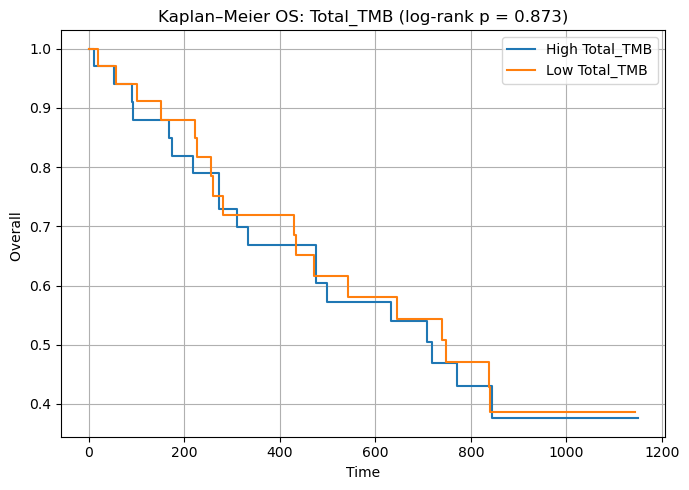

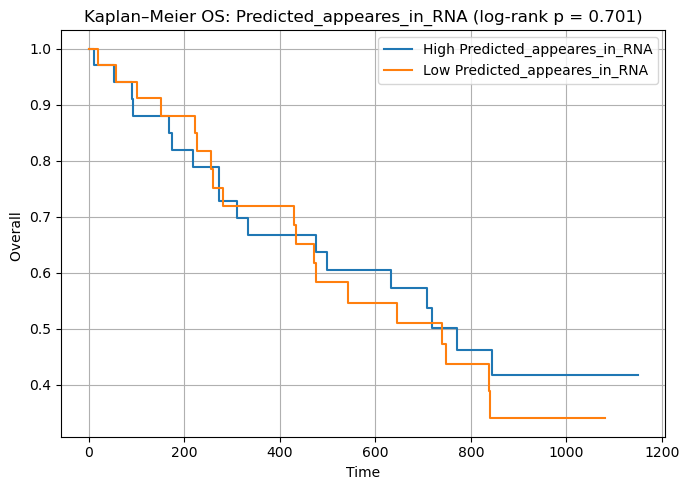

In [410]:
study = 'Melanoma_Riaz'
temp_df = df[df['Study'] == study]

if has_response > 0:
    tmb_auc, tmb_p, exptmb_auc, exptmb_p = evaluate_tmb_response(temp_df[temp_df['Response'].isin(['R', 'NR'])])

# Convert to numeric (safely handles any strings or NaNs)
temp_df['OS(months)'] = pd.to_numeric(temp_df['OS(months)'], errors='coerce')
temp_df['OS(years)'] = pd.to_numeric(temp_df['OS(years)'], errors='coerce')
temp_df['OS(days)'] = pd.to_numeric(temp_df['OS(days)'], errors='coerce')

os_df = temp_df[(~(temp_df['OS(months)'].isna()&temp_df['OS(years)'].isna()&
           temp_df['OS(days)'].isna())) & (~temp_df['OS_status(1=dead, 0=alive)'].isna())]

os_df = compute_os_days(os_df)

tmb_logrank, tmb_direction = plot_km(os_df, 'OS', 'OS_status(1=dead, 0=alive)', 'Total_TMB')
exptmb_logrank, exptmb_direction = plot_km(os_df, 'OS', 'OS_status(1=dead, 0=alive)', 'Predicted_appeares_in_RNA')

In [377]:
df[~df['PFS_status(1=dead, 0=alive)'].isna()]['Study'].value_counts()

Study
genie_nsclc_mutation_data    1511
genie_crc_mutation_data      1331
NSCLC_Blood_Gandara           835
RCC_Braun                     454
egc_msk_2017                  203
Melanoma_Liu                  144
Melanoma_Van_Allen            110
Pan_immunoPog                  92
Pan_Miao                       82
hcc_mskimpact_2018             76
RCC_Hugaboom                   76
RCC_Miao                       35
luad_mskcc_2015                33
Urothelial_Snyder              25
Glioblastoma_Zhao              13
Melanoma_Barras                10
Name: count, dtype: int64

In [367]:
temp_df['PFS'] = temp_df['PFS(days)'].combine_first(temp_df['PFS(months)'] * 30.4375)
temp_df['PFS_status(1=dead, 0=alive)']

58    NaN
59    NaN
60    NaN
61    NaN
62    NaN
63    NaN
64    NaN
65    NaN
66    NaN
67    NaN
68    NaN
69    NaN
70    NaN
71    NaN
72    NaN
73    NaN
74    NaN
75    NaN
76    NaN
77    NaN
78    NaN
79    NaN
80    NaN
81    NaN
82    NaN
83    NaN
84    NaN
85    NaN
86    NaN
87    NaN
88    NaN
89    NaN
90    NaN
91    NaN
92    NaN
93    NaN
94    NaN
95    NaN
Name: PFS(days), dtype: object

Melanoma_Morrison
⚠️ No valid data to plot.
⚠️ No valid data to plot.
Melanoma_Hugo


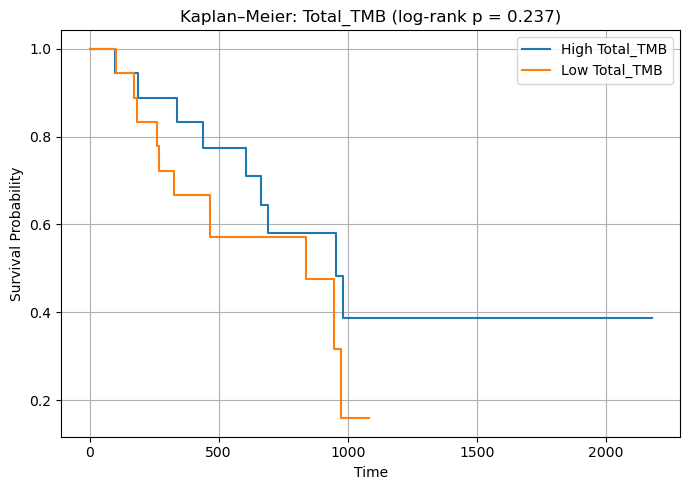

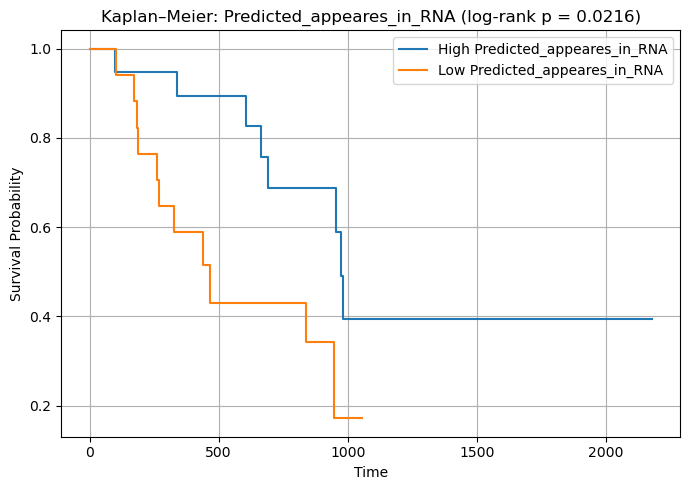

Melanoma_Riaz


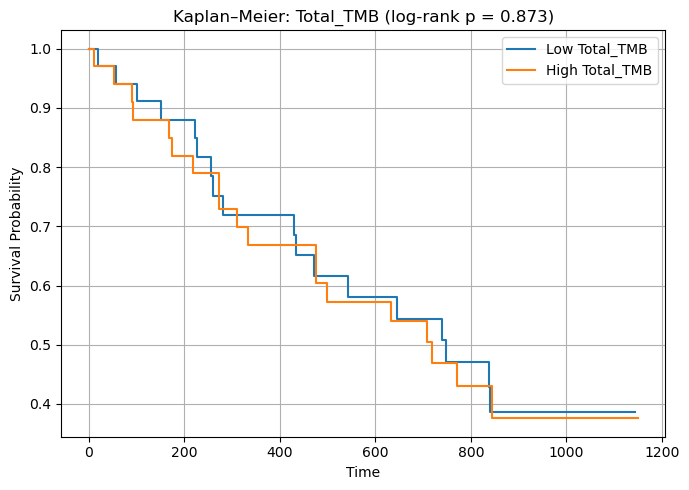

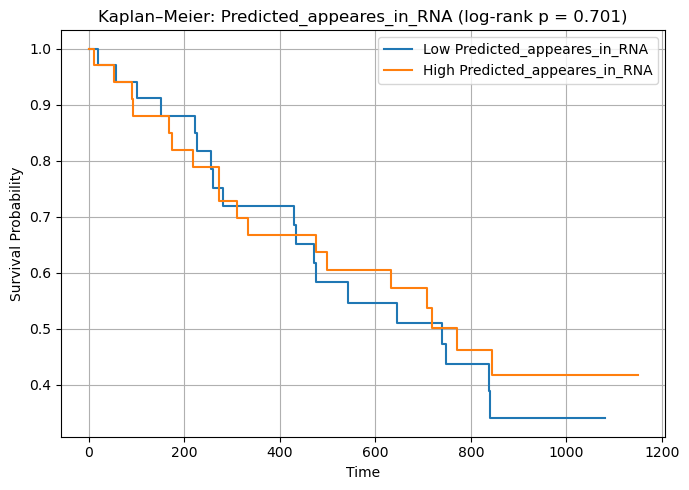

Melanoma_Nathanson_Snyder


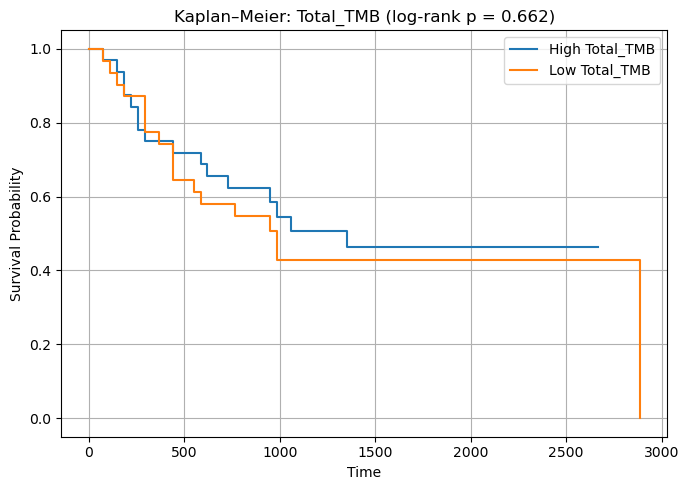

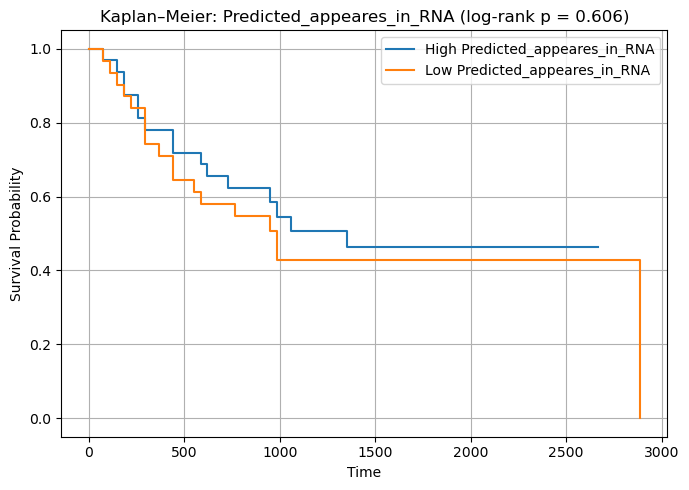

Melanoma_Liu


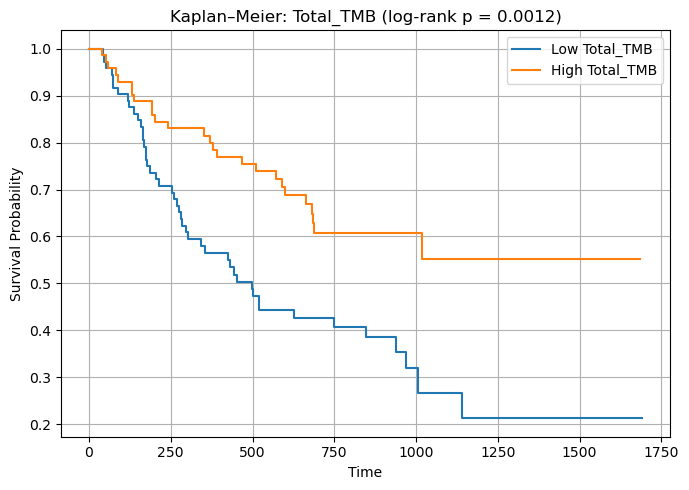

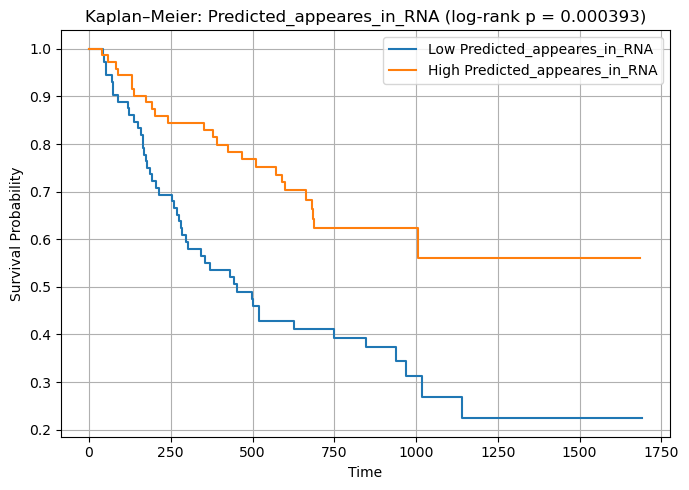

Melanoma_Freeman_MGH


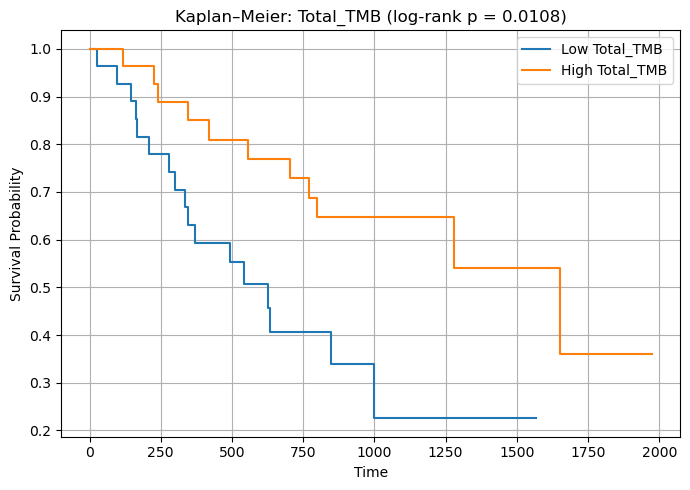

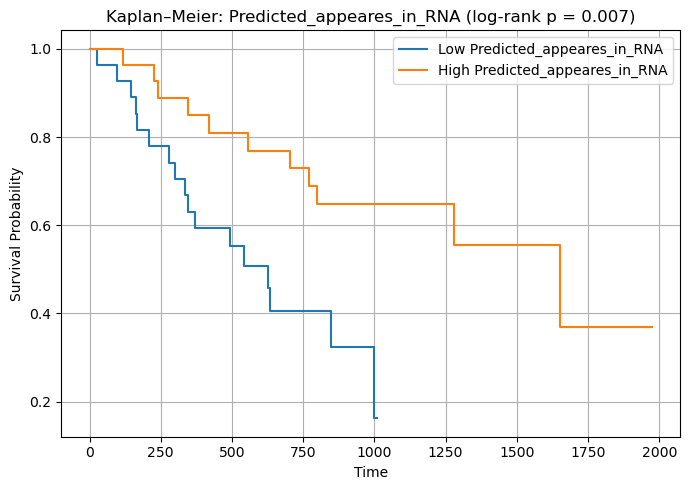

Melanoma_Roh


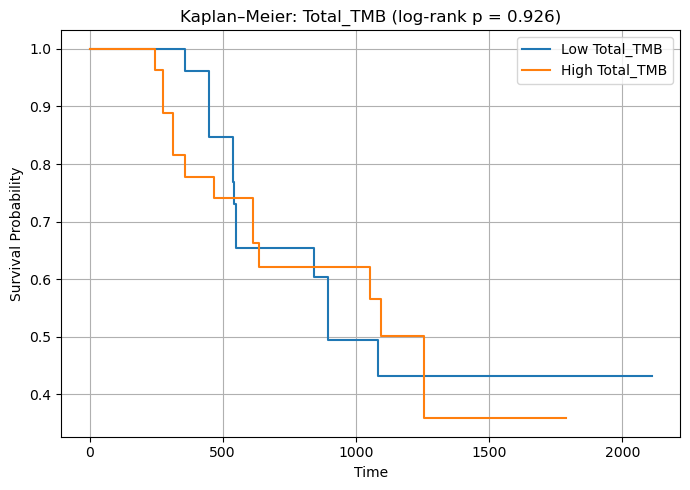

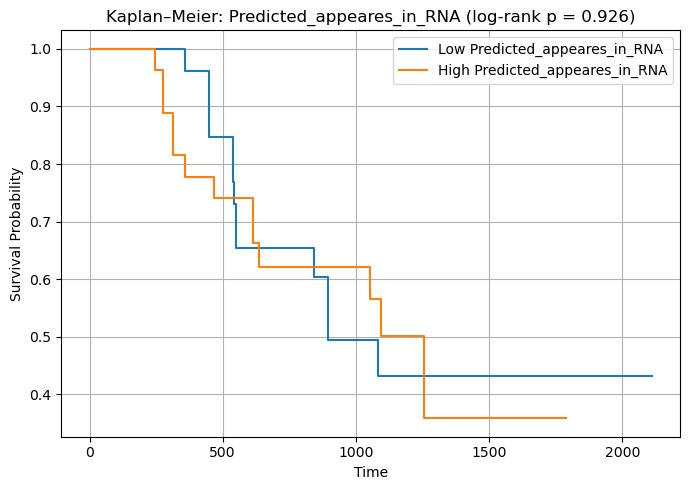

Melanoma_Van_Allen


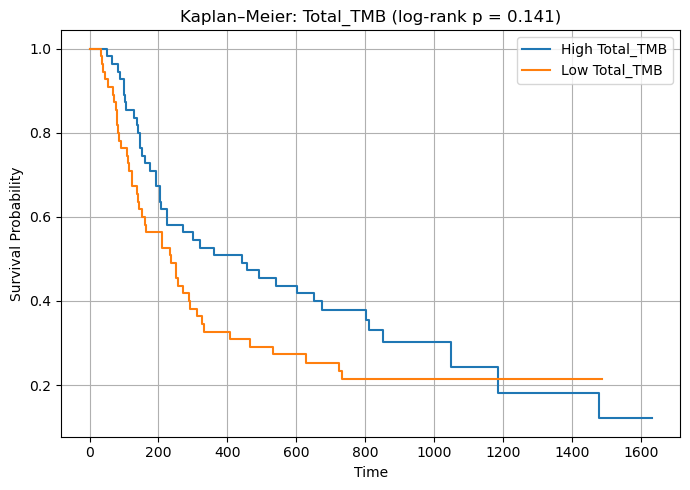

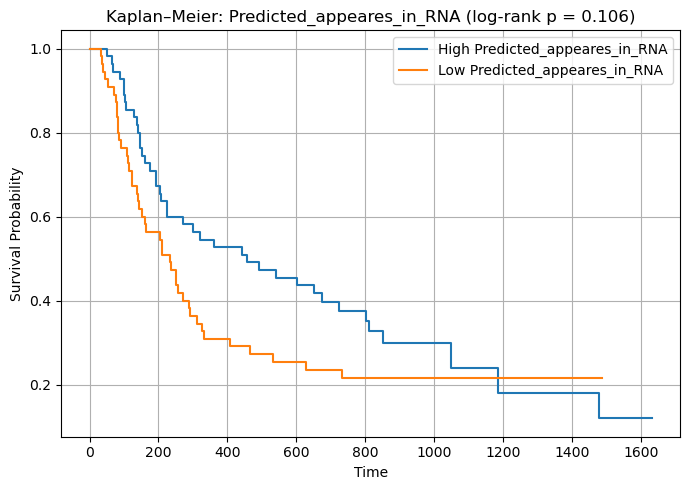

luad_mskcc_2015


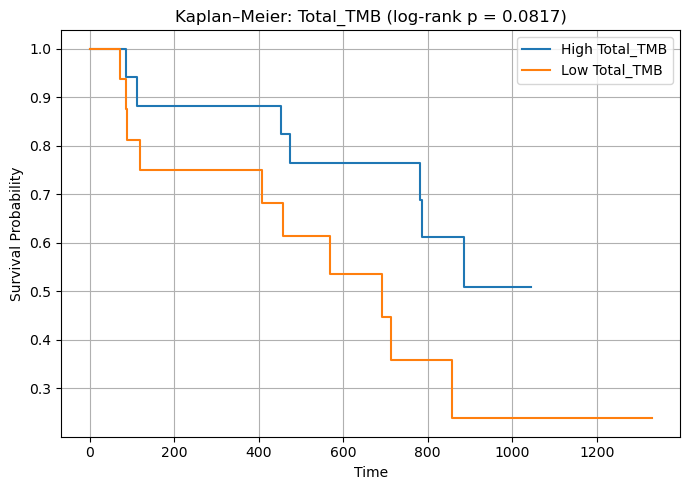

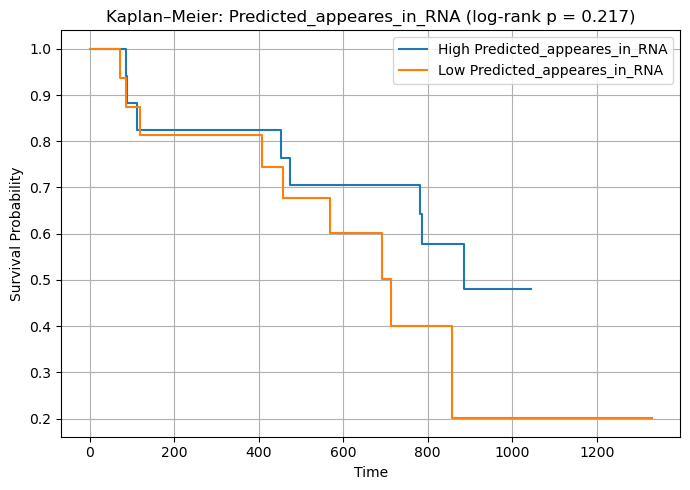

Urothelial_Snyder


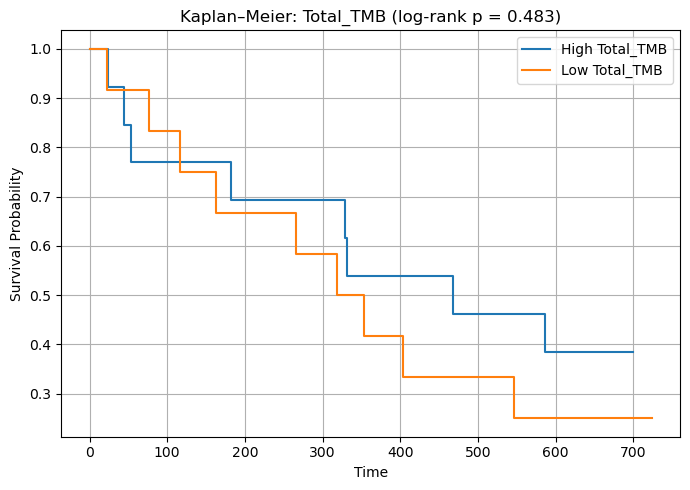

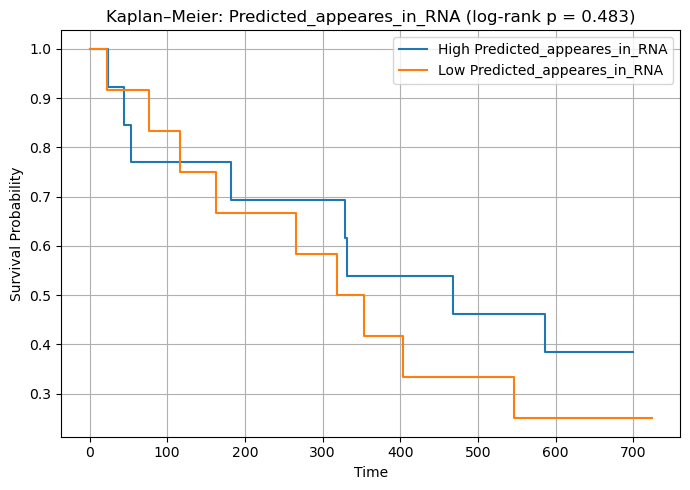

RCC_Miao


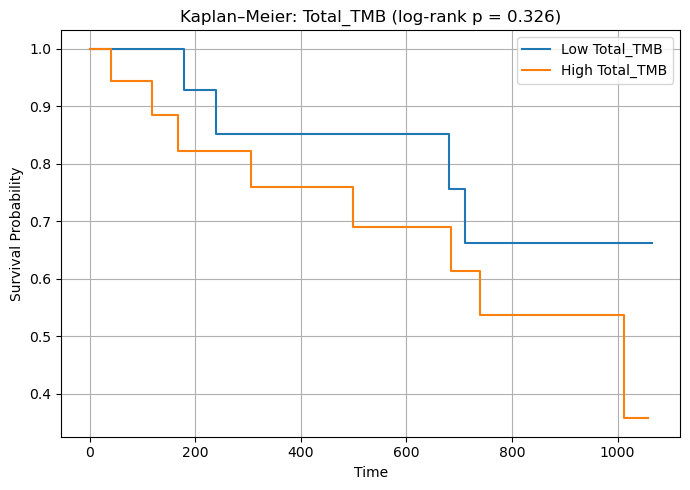

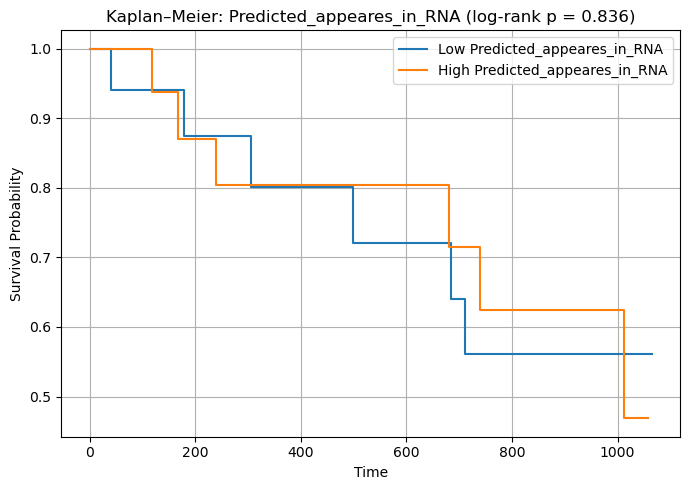

RCC_Braun


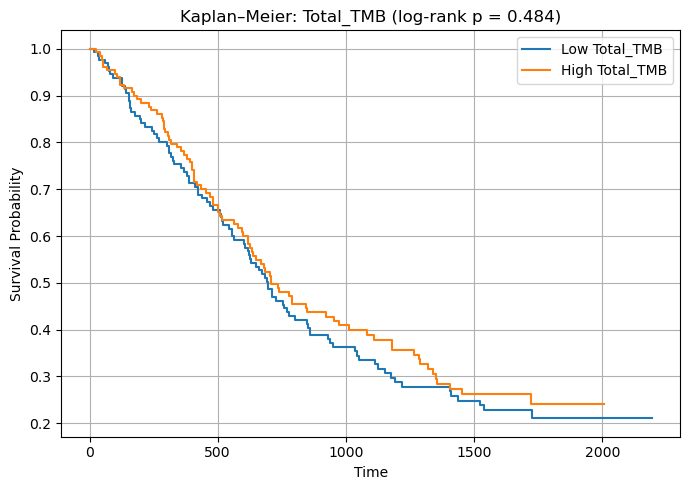

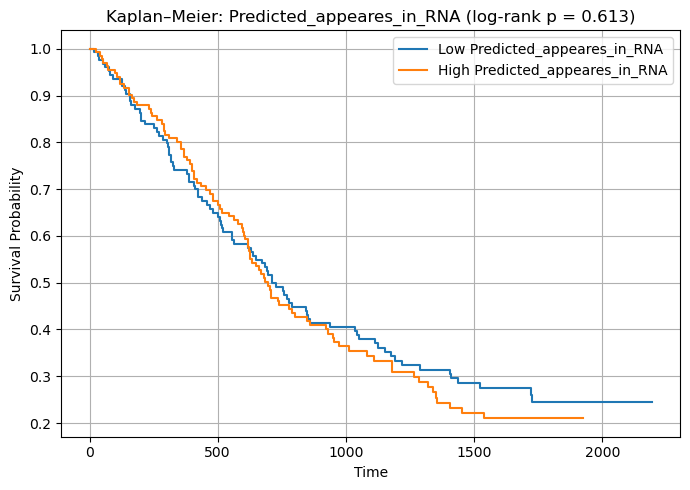

RCC_Jammihal


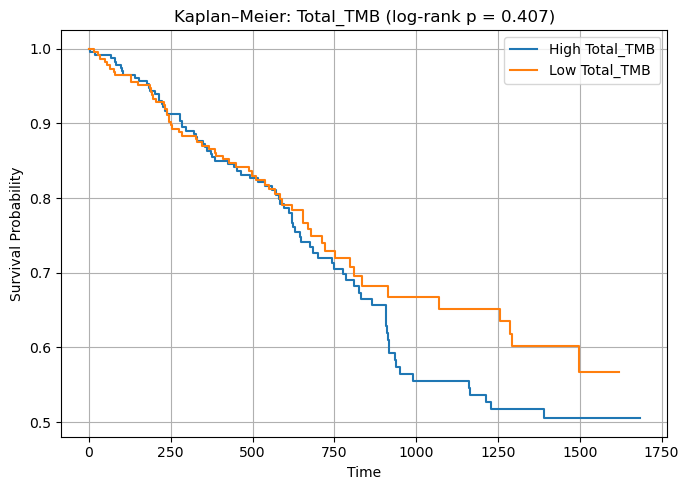

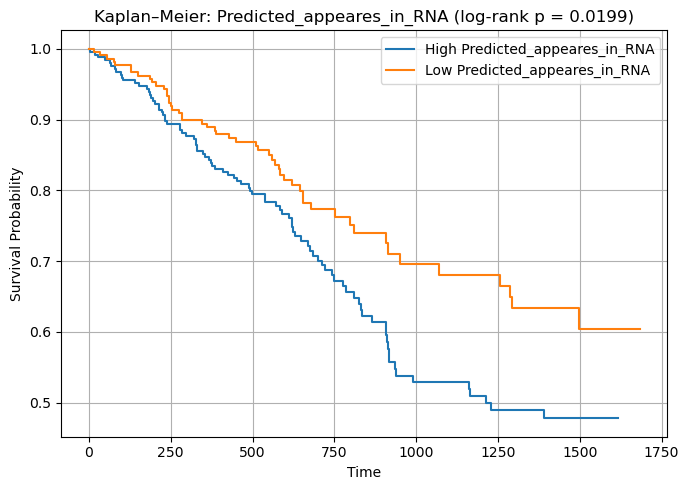

Glioblastoma_Zhao


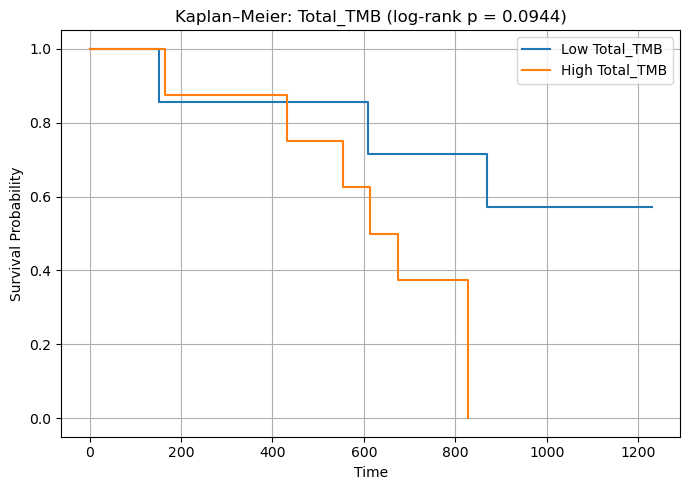

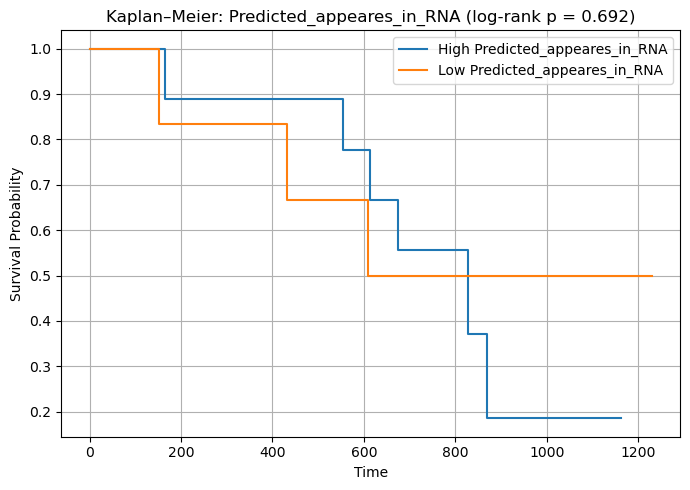

Pan_Miao


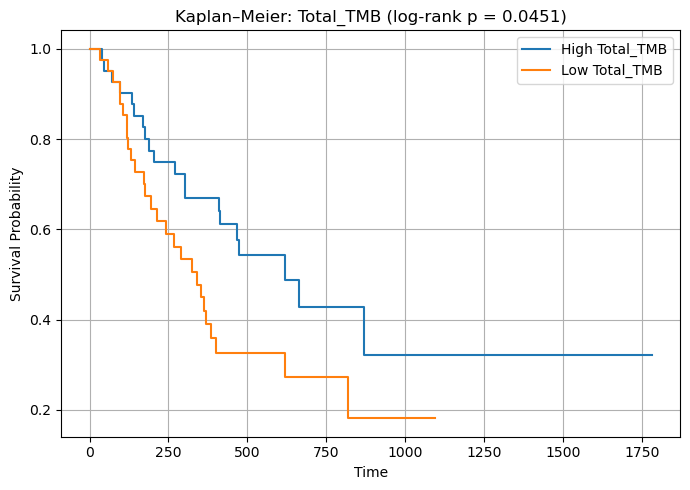

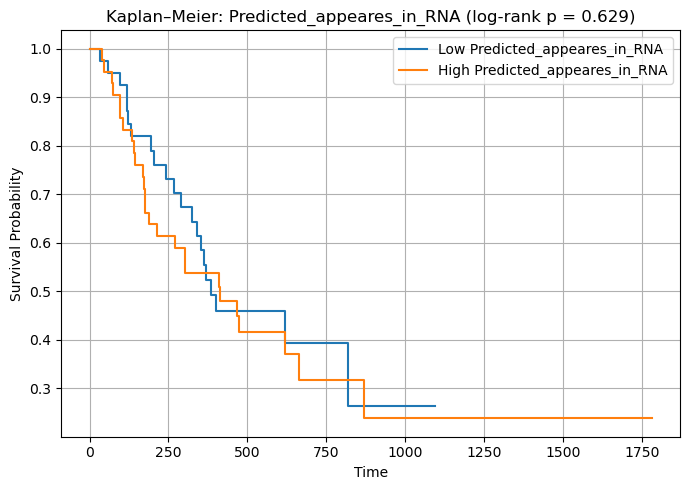

Gastric_PUCH


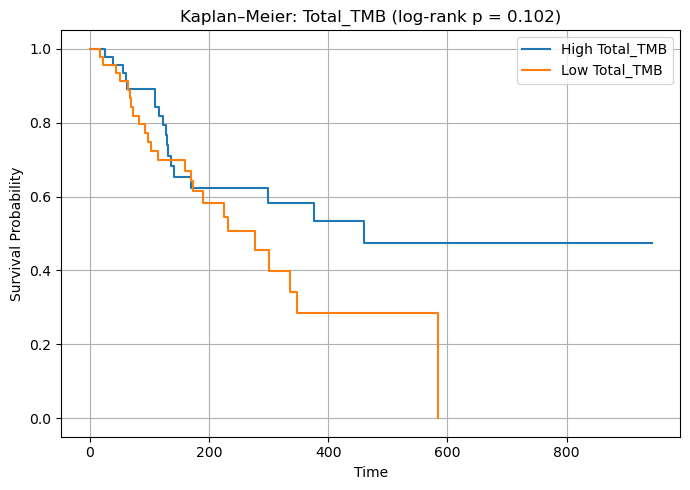

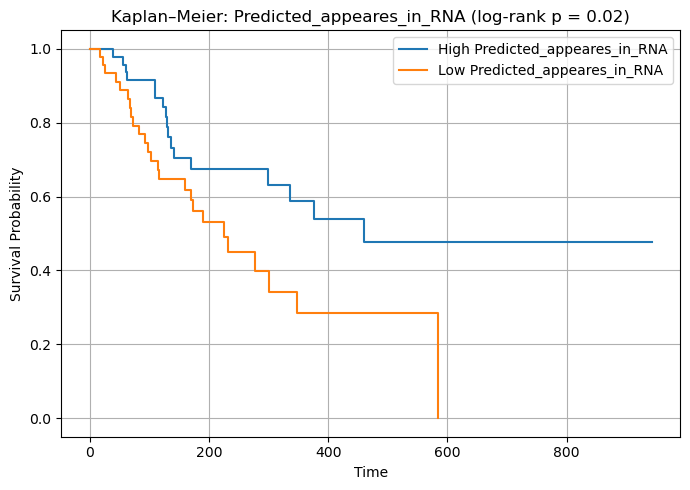

RCC_Hugaboom


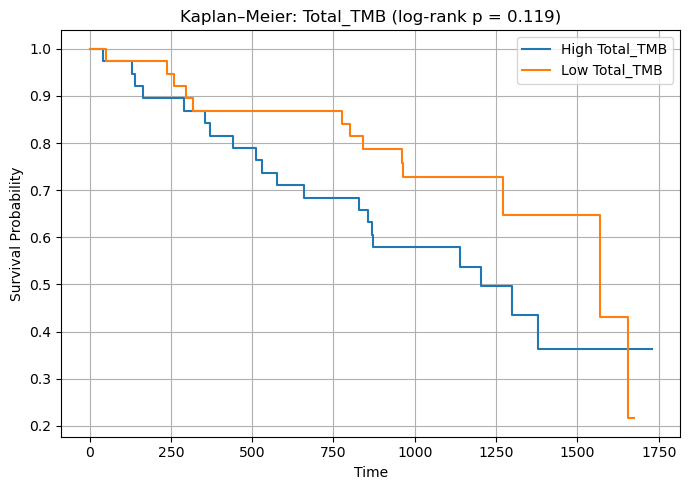

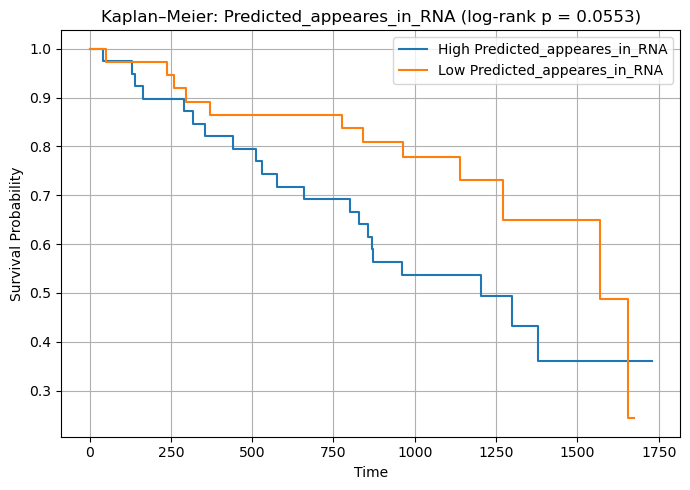

In [330]:
# plot_tmb_comparison(df)
for study in df['Study'].unique():
    temp_df = df[df['Study'] == study]
    if temp_df.shape[0] > 10:
        print(study)
        plot_km(temp_df, 'OS', 'OS_status(1=dead, 0=alive)', 'Total_TMB')
        plot_km(temp_df, 'OS', 'OS_status(1=dead, 0=alive)', 'Predicted_appeares_in_RNA')